In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import random

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import math as m

from utility import log

from networkx.algorithms import approximation
from collections import Counter


from scipy.sparse import csr_matrix

import json



# Preprocessing
Before starting with the actual algorithms we need to apply some prepocessing. For example removing data that is not relevant for our research, and extracting all nodes and links.

In [2]:
# Load the datafile
log("Loading data")
file_path = "data/soc-redditHyperlinks-body.tsv"
raw_data = pd.read_csv(file_path, sep="\t") 

[16:12:03] Loading data


In [3]:
# Remove columns we won't be using
log("Dropping")
data = raw_data.drop(columns=['POST_ID', 'PROPERTIES'])

# Create a list of all nodes
log("Creating list of all nodes")
nodes = pd.concat([data['SOURCE_SUBREDDIT'], data['TARGET_SUBREDDIT']], axis=0)
nodes.drop_duplicates(inplace=True)


log(f"Nodes: {nodes.size:,}")
log(f"Links: {data.shape[0]:,}")

[16:12:13] Dropping
[16:12:13] Creating list of all nodes
[16:12:13] Nodes: 35,776
[16:12:13] Links: 286,561


In [4]:
# Reduce the amount of links to just one direct link.
# This can be useful if we want a more compressed view of the data.
links_compressed = data.drop(columns=["TIMESTAMP"]).groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT']).agg('sum')

log(f"Compressed links: {links_compressed.shape[0]:,}")

[16:12:17] Compressed links: 137,821


In [5]:
log("Preparing nx.MultiDiGraph()...")
mGraph = nx.MultiDiGraph()

log("Adding nodes...")
for node in nodes:
    mGraph.add_node(node)

log("Adding edges...")
for index, edge in data.iterrows():
    mGraph.add_edge(edge['SOURCE_SUBREDDIT'], edge['TARGET_SUBREDDIT'], sentiment=edge['LINK_SENTIMENT'])

[16:12:21] Preparing nx.MultiDiGraph()...
[16:12:21] Adding nodes...
[16:12:21] Adding edges...


Visualization of the Graph

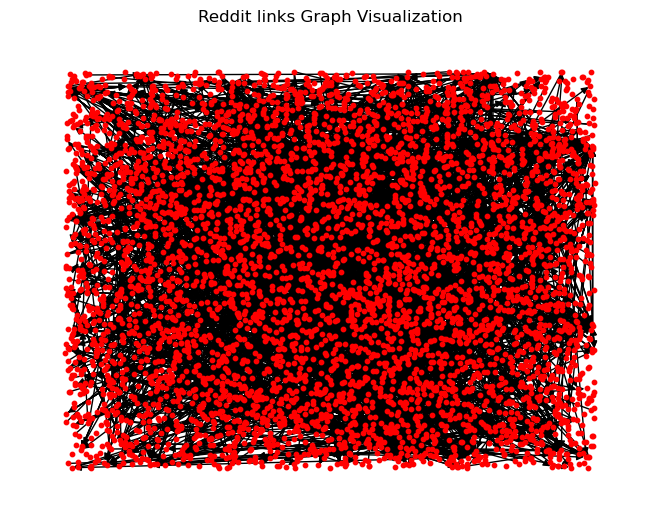

In [7]:
# Sample 2000 nodes for faster computation
all_nodes = list(mGraph.nodes())

# Randomly select nodes from the list
random_nodes = random.sample(all_nodes, 5000)
subgraph = mGraph.subgraph(random_nodes)
# Draw layout of the subgraph
layout = nx.random_layout(subgraph)

# Draw the graph
nx.draw(subgraph, pos=layout, with_labels=False, node_size=10, node_color='red')
plt.title("Reddit links Graph Visualization")
plt.show()

# Anaylsis
This is the analysis of the network

Function to Draw the Graph based on its centrality indices

In [8]:
# Collapse multiple edges as it makes the graph easier to visualize
def collapse_edges(graph):
    # Create a new DiGraph to store the collapsed edges
    collapsed_graph = nx.DiGraph()

    # Iterate through the edges of the original graph
    for source, target in graph.edges():
        if not collapsed_graph.has_edge(source, target):
            # If the edge doesn't exist in the collapsed graph, add it
            collapsed_graph.add_edge(source, target)

    return collapsed_graph



def show_graph(graph, degree_values, title, degree_name, total_nodes, scale_factor):
    collapsed_graph = collapse_edges(graph)
    # Sort the degree values DataFrame
    sorted_centrality_values = degree_values.sort_values(by=degree_name, ascending=False)

    # Select the top 100 nodes based on degree
    top_nodes = sorted_centrality_values.iloc[:total_nodes]

    # Color map from yellow to purple
    colormap = plt.cm.viridis
    reversed_colormap = colormap.reversed()
    norm = Normalize(vmin=min(top_nodes[degree_name]), vmax=max(top_nodes[degree_name]))
    


    # Create the figure
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [1, 0.1]})

    # Create a subgraph and add degree values as attributes
    subgraph_nodes = list(top_nodes['SOURCE'])
    subgraph = collapsed_graph.subgraph(subgraph_nodes)
    for node in subgraph:
        subgraph.nodes[node][degree_name] = degree_values[degree_values['SOURCE'] == node][degree_name].values[0]
    
    # Create the graph layout
    pos = nx.circular_layout(subgraph, scale=1, center=(0,0))
    # Define node sizes based on centrality values
    node_sizes = [subgraph.nodes[node][degree_name] * scale_factor for node in subgraph]
    
    # Create a dictionary of edge colors based on the source node's degree value
    edge_colors = {(edge[0], edge[1]): subgraph.nodes[edge[0]][degree_name] for edge in subgraph.edges()}
    
    # Create a list of edge tuples from the dictionary keys
    edge_list = list(edge_colors.keys())

    # Draw the graph with specified node size, node color, and edge colors
    node_color = [subgraph.nodes[node][degree_name] for node in subgraph]
    nx.draw(subgraph, pos=pos, connectionstyle="arc3,rad=0.2", node_size=node_sizes, node_color=node_color, with_labels=True, font_size=8,
            cmap=reversed_colormap, edgelist=edge_list, edge_color=list(edge_colors.values()), edge_cmap=reversed_colormap,
            edge_vmin=min(node_color), edge_vmax=max(node_color), ax=ax[0])

    # Create the color scale on the right side
    sm = plt.cm.ScalarMappable(cmap=reversed_colormap, norm=norm)
    sm.set_array([])
    colorbar = plt.colorbar(sm, cax=ax[1])
    colorbar.set_label('Index Color Scale')

    fig.suptitle(title, fontsize=14)

    # Show the plot
    plt.show()

In [9]:
log(f"mGraph > Vertices: \t{mGraph.number_of_nodes():,}")
log(f"mGraph > Edges: \t{mGraph.number_of_edges():,}")

in_degree = pd.DataFrame(mGraph.in_degree(), columns=['SOURCE', 'degree'])
out_degree = pd.DataFrame(mGraph.out_degree(), columns=['SOURCE', 'degree'])

in_degree.sort_values('degree', ascending=False, inplace=True)
out_degree.sort_values('degree', ascending=False, inplace=True)

log("In degree: (Most referenced subreddits)")
print(in_degree.head(5))

log("Out degree: (Referencing other subreddits)")
print(out_degree.head(5))


[16:14:05] mGraph > Vertices: 	35,776
[16:14:05] mGraph > Edges: 	286,561
[16:14:05] In degree: (Most referenced subreddits)
               SOURCE  degree
34          askreddit    7329
22               iama    3694
7741             pics    2779
42     writingprompts    2490
11294          videos    2446
[16:14:05] Out degree: (Referencing other subreddits)
               SOURCE  degree
70     subredditdrama    4665
16        circlebroke    2358
6400  shitliberalssay    1968
126      outoftheloop    1958
79          copypasta    1824


Function to prune nodes to accellerate computation

In [10]:
# Prune low connectivity nodes to speed up the computation of certain properties of the graph
def prune_nodes(G, total_degree_centrality):
    threshold = 300
    graph_copy = G.copy()
    nodes_to_remove = total_degree_centrality[total_degree_centrality['total_degree_centrality'] < threshold]['SOURCE'].tolist()
    graph_copy.remove_nodes_from(nodes_to_remove)
    total_nodes = graph_copy.number_of_nodes()
    total_edges = graph_copy.number_of_edges()
    print(f"Total Nodes after Pruning: {total_nodes}")
    print(f"Total Edges after Pruning: {total_edges}")
    return graph_copy

Calculation of centrality indices: Degree Centrality, Betweenness Centrality, Closeness Centrality and Eigenvector Centrality

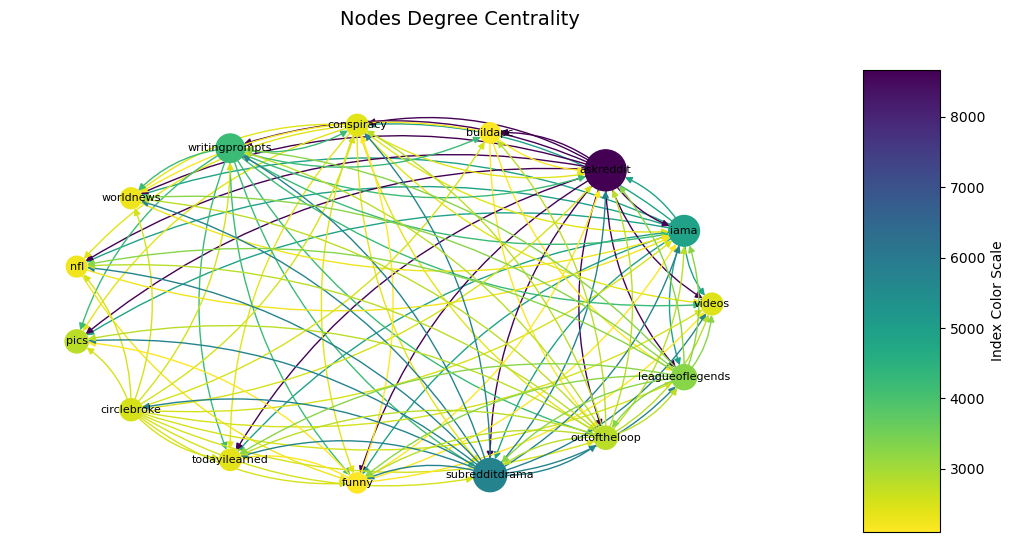

[16:14:24] Total Degree-centrality:
             SOURCE  degree_in  degree_out  total_degree_centrality
0         askreddit       7329        1338                     8667
21   subredditdrama       1053        4665                     5718
1              iama       3694        1181                     4875
3    writingprompts       2490        1707                     4197
5   leagueoflegends       2420         840                     3260


In [11]:
# Calculate (In/Out)-Degree centrality (in and out degree)
total_degree = in_degree.merge(out_degree, on='SOURCE', suffixes=('_in', '_out'))
total_degree['total_degree_centrality'] = total_degree['degree_in'] + total_degree['degree_out']
total_degree_centrality = total_degree.sort_values('total_degree_centrality', ascending=False)

# Show in output the results
# We do not show too many as there are many connections and we don't want the results to be too cluttered
show_graph(mGraph, total_degree_centrality, "Nodes Degree Centrality", 'total_degree_centrality', 15, 0.1)

log("Total Degree-centrality:")
print(total_degree_centrality.head(5))

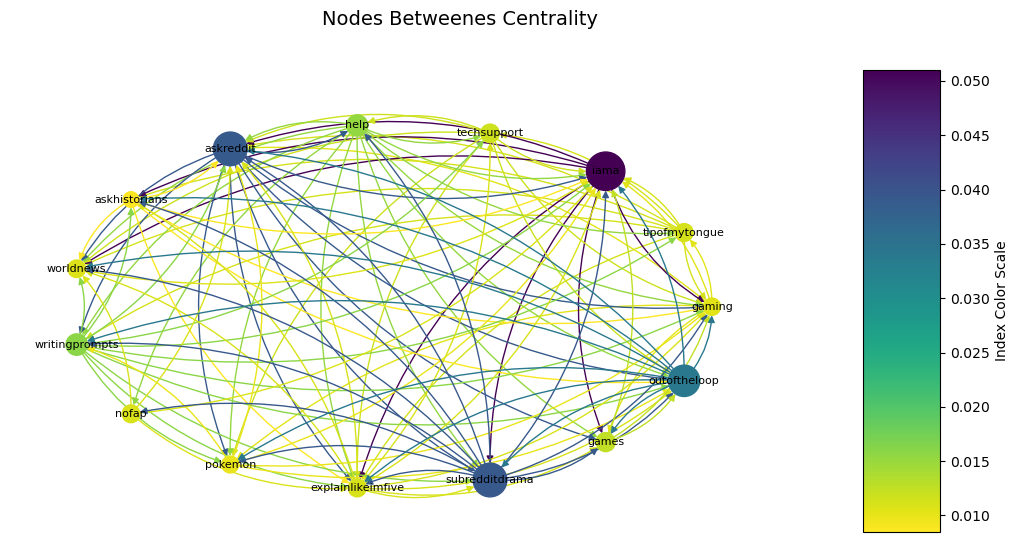

[16:15:25] Betweenness Centrality: (Influence of node in graph)
             SOURCE  betweenness_centrality
22             iama                0.051003
70   subredditdrama                0.039307
34        askreddit                0.039100
126    outoftheloop                0.033979
42   writingprompts                0.015812


In [12]:
# Calculate betweenness centrality using an approximation measure for time reasons
# If we calculate betweenness centrality for k=n then it will take too much (we can use a sample of k nodes)

betweennes_calculation = nx.betweenness_centrality(mGraph, k = 100, weight = 'LINK_SENTIMENT')
betweenness_centrality = pd.DataFrame(betweennes_calculation.items(), columns=['SOURCE', 'betweenness_centrality'])

betweenness_centrality = betweenness_centrality.sort_values('betweenness_centrality', ascending=False)

show_graph(mGraph, betweenness_centrality, "Nodes Betweenes Centrality", 'betweenness_centrality', 15, 15000)
log("Betweenness Centrality: (Influence of node in graph)")
print(betweenness_centrality.head(5))

Total Nodes after Pruning: 314
Total Edges after Pruning: 56691


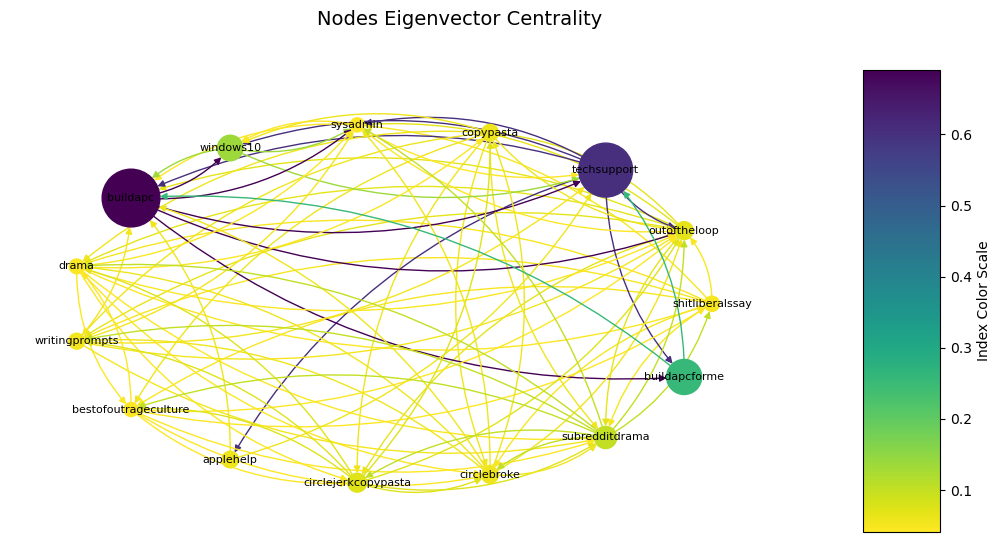

[16:15:36] Top 5 Nodes by Eigenvector Centrality:
             SOURCE  eigenvector_centrality
51         buildapc                0.690689
131     techsupport                0.603486
163   buildapcforme                0.254779
293       windows10                0.135070
24   subredditdrama                0.101864


In [13]:
# Calculate eigenvector centrality. We need a function
# which does that for multiGraph instead of singleGraph
# Used the same start parameters (mat_iter and tol) as NetworkX
def m_eigenvector_centrality(G, max_iter=100, tol=1e-6):
    # Prune some nodes of the matrix otherwise my PC crashes!
    G_copy = prune_nodes(G, total_degree_centrality)
    # Make an adjacency matrix
    adjacency_matrix = csr_matrix(nx.adjacency_matrix(G_copy))

    # Array to save eigenvector centrality for each node
    num_nodes = len(G_copy.nodes())
    eigenvector = np.full(num_nodes, 1.0 / num_nodes)

    for _ in range(max_iter):
        # Calculate the matrix-vector product
        new_eigenvector = np.dot(adjacency_matrix.toarray(), eigenvector)

        # Normalize
        norm = np.linalg.norm(new_eigenvector)
        new_eigenvector = new_eigenvector / norm

        # Repeat until convergence (or max_iter)
        if np.linalg.norm(new_eigenvector - eigenvector) < tol:
            return dict(zip(G_copy.nodes(), new_eigenvector))

        eigenvector = new_eigenvector

    return dict(zip(G_copy.nodes(), eigenvector))

eigenvector_calculation = m_eigenvector_centrality(mGraph)
eigenvector_centrality = pd.DataFrame(eigenvector_calculation.items(), columns=['SOURCE', 'eigenvector_centrality'])
eigenvector_centrality = eigenvector_centrality.sort_values('eigenvector_centrality', ascending=False)

show_graph(mGraph, eigenvector_centrality, "Nodes Eigenvector Centrality", 'eigenvector_centrality', 15,2500)

log("Top 5 Nodes by Eigenvector Centrality:")
print(eigenvector_centrality.head(5))

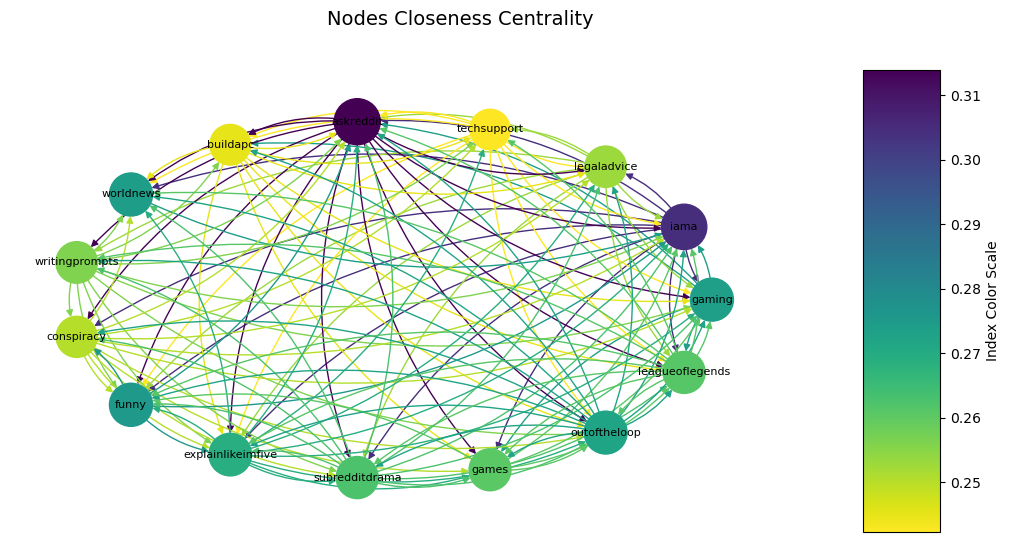

[16:16:40] Top 5 Nodes by Closeness Centrality:
       SOURCE  closeness_centrality
0   askreddit              0.313944
1        iama              0.304565
18      funny              0.275427
10  worldnews              0.274397
11     gaming              0.273803


In [14]:
# Use a subset of nodes to calculate closeness centrality for. The subset is chosen as
# the combination of other centrality values

scaler = MinMaxScaler()

combined_centrality = total_degree_centrality.merge(betweenness_centrality, on='SOURCE')
combined_centrality = combined_centrality.merge(eigenvector_centrality, on='SOURCE')
# Scale the values
combined_centrality['total_degree_centrality'] =  scaler.fit_transform(combined_centrality['total_degree_centrality'].values.reshape(-1, 1))
combined_centrality['betweenness_centrality'] =  scaler.fit_transform(combined_centrality['betweenness_centrality'].values.reshape(-1, 1))
combined_centrality['eigenvector_centrality'] =  scaler.fit_transform(combined_centrality['eigenvector_centrality'].values.reshape(-1, 1))

# Just sum the values
combined_centrality['combined_centrality'] = (
    combined_centrality['total_degree_centrality'] +
    combined_centrality['betweenness_centrality'] +
    combined_centrality['eigenvector_centrality']
)

combined_centrality = combined_centrality.sort_values('combined_centrality', ascending=False)
# Select the top 20
top_nodes = combined_centrality.head(20)
top_nodes_list = top_nodes['SOURCE'].tolist()

closeness_centrality_calc = {}

for node in top_nodes_list:
    closeness_centrality_calc[node] = nx.closeness_centrality(mGraph, u=node)
closeness_centrality = pd.DataFrame(closeness_centrality_calc.items(), columns=['SOURCE', 'closeness_centrality'])
closeness_centrality = closeness_centrality.sort_values('closeness_centrality', ascending=False)

show_graph(mGraph, closeness_centrality, "Nodes Closeness Centrality", 'closeness_centrality', 15, 3500)

log("Top 5 Nodes by Closeness Centrality:")
print(closeness_centrality.head(5))

Calculation of Clustering Coefficient

In [15]:
# As before, we need to make our own function since
# networkX does not work for MultiDiGraphs
def f_clustering_coefficient(G, node):
    # Get the neighbors of the given node
    neighbors = set(G.neighbors(node))

    # If there are no neighbors then return 0
    if len(neighbors) < 2:
        return 0.0

    # Find the number of edges between neighbors
    edges_between_neighbors = 0

    for u in neighbors:
        for v in neighbors:
            if u != v and G.has_edge(u, v):
                # Usually edge weights are not considered, hence we just add +1
                edges_between_neighbors += 1

    # Calculate the clustering coefficient
    clustering_coefficient = edges_between_neighbors / (len(neighbors) * (len(neighbors) - 1))
    return clustering_coefficient


clustering_coefficient_calc = {}
for node in mGraph.nodes():
    clustering_coefficient_calc[node] = f_clustering_coefficient(mGraph, node)

clustering_coefficient = pd.DataFrame(clustering_coefficient_calc.items(), columns=['SOURCE', 'clustering_coefficient'])
count_of_ones = len(clustering_coefficient[clustering_coefficient['clustering_coefficient'] == 1])

# 1 is the highest clustering coefficient value
log("Number of nodes with a clustering coefficient = 1:")
print(count_of_ones)


[16:16:50] Number of nodes with a clustering coefficient = 1:
1498


Network Diameter + Number of Connected Components + Size of connected components + Density

In [16]:
strongly_connected_components = list(nx.strongly_connected_components(mGraph))
component_sizes = [len(component) for component in strongly_connected_components]
sorted_sizes = sorted(component_sizes, reverse=True)

log("Number of Strongly Connected Components:")
total_Scc = len(strongly_connected_components)
print(total_Scc)
log("Top 5 Strongly Connected Components by size:")
for i, size in enumerate(sorted_sizes[:5], start=1):
    print(f"Component {i}: Size = {size} nodes")

density = nx.density(mGraph)
log("The density of the Graph is")
print(density)

# Calculate diameter only for the biggest SCC
largest_scc = max(strongly_connected_components, key=len)
largest_scc_subgraph = mGraph.subgraph(largest_scc)
# diameter = nx.diameter(largest_scc_subgraph, weight="weight", usebounds=True)
diameter = approximation.diameter(largest_scc_subgraph)

log("Diameter approximation of largest SCC:")
print(diameter)

[16:16:53] Number of Strongly Connected Components:
24071
[16:16:53] Top 5 Strongly Connected Components by size:
Component 1: Size = 11564 nodes
Component 2: Size = 6 nodes
Component 3: Size = 5 nodes
Component 4: Size = 4 nodes
Component 5: Size = 4 nodes
[16:16:53] The density of the Graph is
0.00022389565198911403
[16:16:57] Diameter approximation of largest SCC:
12


Find and Show Cliques 

Largest Clique 1, Length 33: ['denverbroncos', 'nfl', 'panthers', 'texans', 'nyjets', 'saints', 'chargers', 'azcardinals', 'cowboys', 'buffalobills', 'greenbaypackers', 'nygiants', 'nfl_draft', 'buccaneers', 'minnesotavikings', 'eagles', 'detroitlions', 'ravens', 'jaguars', '49ers', 'chibears', 'steelers', 'seahawks', 'colts', 'oaklandraiders', 'falcons', 'miamidolphins', 'bengals', 'browns', 'kansascitychiefs', 'losangelesrams', 'redskins', 'patriots']
Largest Clique 2, Length 33: ['denverbroncos', 'nfl', 'panthers', 'texans', 'nyjets', 'saints', 'chargers', 'azcardinals', 'cowboys', 'buffalobills', 'greenbaypackers', 'nygiants', 'nfl_draft', 'buccaneers', 'minnesotavikings', 'eagles', 'detroitlions', 'ravens', 'jaguars', '49ers', 'chibears', 'steelers', 'seahawks', 'colts', 'oaklandraiders', 'falcons', 'miamidolphins', 'bengals', 'browns', 'kansascitychiefs', 'losangelesrams', 'redskins', 'tennesseetitans']
Largest Clique 3, Length 10: ['pmmodi', 'vmware', 'nvidiashield', 'iupui', 'm

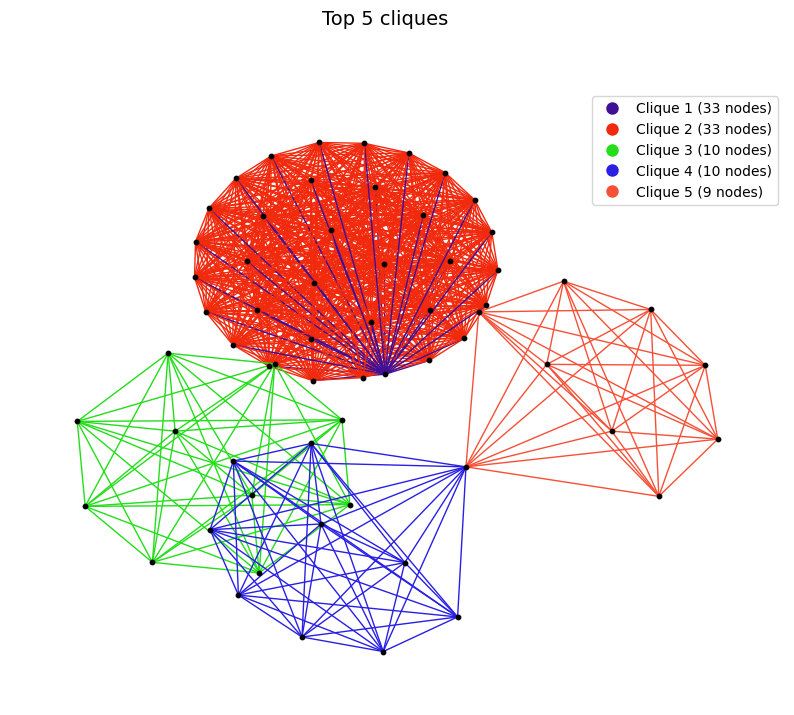

In [21]:
# Convert to undirected graph. Explanation to why this is fine (https://stackoverflow.com/questions/12896477/cliques-for-directed-graphs-in-igraph)
undirected_graph = nx.Graph()

# Add an edge (u,v) in the undirected graph iff in our multidigraph we have
# (u,v) and (v,u)
for u, v in mGraph.edges():
    # Check if there is an edge (v, u) in the MultiDiGraph
    if mGraph.has_edge(v, u):
        undirected_graph.add_edge(u, v)

cliques = list(nx.find_cliques(undirected_graph))

sorted_cliques = sorted(cliques, key=lambda x: len(x), reverse=True)

# Print the 5 largest cliques
for i, clique in enumerate(sorted_cliques[:5], start=1):
    print(f"Largest Clique {i}, Length {len(clique)}: {clique}")

# Represent cliques. Random color for each one
clique_colors = {}
for i, clique in enumerate(sorted_cliques[:5]):
    color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    clique_colors[i] = color

# Create an empty graph
clique_graph = nx.Graph()

# Add nodes and edges for the top 5 cliques with unique colors
for i, clique in enumerate(sorted_cliques[:5]):
    for node in clique:
        clique_graph.add_node(node)
    for u in clique:
        for v in clique:
            if u != v:
                # Assign the color of the current clique to the edge
                edge_color = clique_colors[i]
                clique_graph.add_edge(u, v, color=edge_color)

# Extract edge colors from the graph
edge_colors = [clique_graph[u][v]['color'] for u, v in clique_graph.edges()]

pos = nx.kamada_kawai_layout(clique_graph)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the graph with the Kamada-Kawai layout
nx.draw(
    clique_graph,
    pos,
    node_color='black',
    node_size=10,
    edge_color=edge_colors,
    with_labels=False,
    font_size=10,
    ax=ax,
)

# Create a legend
legend_labels = [f'Clique {i+1} ({len(sorted_cliques[i])} nodes)' for i in range(5)]
legend_colors = [clique_colors[i] for i in range(5)]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markersize=10, markerfacecolor=color) for label, color in zip(legend_labels, legend_colors)]

# Add the legend to the axis
ax.legend(handles=legend_elements, loc='upper right')
fig.suptitle("Top 5 cliques", fontsize=14)
# P.S: Legal advice connects two cliques
plt.show()

Run homophily test with NSFW and SFW subreddits

In [31]:
# Open the JSON file for reading
with open("subs.json", "r") as json_file:
    # Load the JSON data from the file
    data = json.load(json_file)

# Extract all the names into a list
nsfw_subs = list(data.keys())
nsfw_Graph = mGraph.copy()
# Create dictionary
nsfw_subs_dict = {name: True for name in nsfw_subs}
nsfw_count = 0
sfw_count = 0
for node in mGraph.nodes:
    if node in nsfw_subs_dict:
        nsfw_count += 1
        mGraph.nodes[node]["nsfw"] = True 
    else:
        sfw_count += 1
        mGraph.nodes[node]["nsfw"] = False  

total_nodes = nsfw_count + sfw_count
# Probability to have an edge between SFW and NSFW subreddits
edge_probability = 2*(nsfw_count/total_nodes)*(sfw_count/total_nodes)

# Calculate number of edges between SFW and NSFW
nsfw_to_sfw_edges = 0
sfw_to_nsfw_edges = 0
total_edges = 0
for edge in mGraph.edges:
    total_edges += 1
    source_node, target_node, _ = edge

    # Check the "nsfw" attribute of the source and target nodes
    source_nsfw = mGraph.nodes[source_node].get("nsfw", False)
    target_nsfw = mGraph.nodes[target_node].get("nsfw", False)

    # Count the edge based on the node attributes
    if source_nsfw and not target_nsfw:
        nsfw_to_sfw_edges += 1
    elif not source_nsfw and target_nsfw:
        sfw_to_nsfw_edges += 1

nsfw_to_sfw_ratio = (nsfw_to_sfw_edges + sfw_to_nsfw_edges)/total_edges

# Basically the ratio of number of NSFW-SFW edges to the expected number of those.
# The lower the ratio the higher homophily between the groups
log("Homophily 'score':")
print(nsfw_to_sfw_ratio/edge_probability)

[13:52:00] Homophily 'score':
0.7263466594893151


Important nodes acting as Bridges. Calculation for MultiDiGraph (Paper: https://core.ac.uk/reader/82453490) 

In [27]:
# We say that a bridge in a Graph is a strong bridge if removing it
# increases the number of SCC (ref: paper above)

def find_bridges(G):
    bridges = []

    total_scc = len(list(nx.strongly_connected_components(G)))
    graph_copy = G.copy()
    count = 0
    for u, v in G.edges():
        if count % 5000 == 0:
            print(f"Processed {count} edges")
        count += 1
        # Temporarily remove the edge (u, v)
        graph_copy.remove_edge(u, v)
        new_scc_count = len(list(nx.strongly_connected_components(graph_copy)))

        # If the number of new SCC < original SCC then the edge is bridge
        if new_scc_count > total_scc:
            bridges.append((u, v))

        # Restore edge (u, v)
        graph_copy.add_edge(u, v)
    return bridges

# Find bridge edges in the undirected graph
bridge_edges = list(find_bridges(prune_nodes(mGraph,total_degree_centrality)))
print(bridge_edges)
bridge_nodes = [node for edge in bridge_edges for node in edge]

# Count the occurrences of each node
top_nodes = Counter(bridge_nodes)

# Get the top 5 nodes with the highest counts
top_nodes = top_nodes.most_common(5)

# Print the top 5 nodes
print("Top 5 Nodes in Bridge Edges:")
for node, count in top_nodes:
    print(f"Node: {node}, Count: {count}")

Total Nodes after Pruning: 314
Total Edges after Pruning: 56691
Processed 0 edges
Processed 5000 edges
Processed 10000 edges
Processed 15000 edges
Processed 20000 edges
Processed 25000 edges
Processed 30000 edges
Processed 35000 edges
Processed 40000 edges
Processed 45000 edges
Processed 50000 edges
Processed 55000 edges
[('footballhighlights', 'soccer'), ('gifs', 'resissues'), ('pics', 'changelog'), ('ironthronepowers', 'bugs'), ('modelusgov', 'mhoc')]
Top 5 Nodes in Bridge Edges:
Node: footballhighlights, Count: 1
Node: soccer, Count: 1
Node: gifs, Count: 1
Node: resissues, Count: 1
Node: pics, Count: 1


Important nodes acting as Bridges. Calculation for Undirected graph

In [307]:
simple_graph = mGraph.to_undirected()

# Find bridge edges in the undirected graph
bridge_edges = list(nx.bridges(simple_graph))

bridge_nodes = [node for edge in bridge_edges for node in edge]

# Count the occurrences of each node
top_nodes = Counter(bridge_nodes)

# Get the top 5 nodes with the highest counts
top_nodes = top_nodes.most_common(15)

c = 0
# Print the top 5 nodes
print("Top 5 Nodes in Bridge Edges (undirected graphs):")
for node, count in top_nodes:
    print(f"Node: {node}, Count: {count}")
    c += 1
    if c >= 5:
        break

# SHOW STUFF HERE

Top 5 Nodes in Bridge Edges (undirected graphs):
Node: askreddit, Count: 291
Node: writingprompts, Count: 188
Node: tipofmypenis, Count: 188
Node: iama, Count: 183
Node: mhoc, Count: 133


Implement Louvain (alternative to Girvan-Newman) algorithm 

In [311]:
# Louvain algorithm is more time efficient thant Girvan Newman
result = nx.community.louvain_communities(mGraph, weight = 'LINK_SENTIMENT')

community_sizes = [(community, len(community)) for community in result]

# Sort communities by size in descending order
sorted_communities = sorted(community_sizes, key=lambda x: x[1], reverse=True)

log("Top 5 communities by size identified by Louvain method:")
# Print the 5 largest communities along with their sizes
for i, (community, size) in enumerate(sorted_communities[:5], start=1):
    print(f"Community {i}: Size = {size}")

[16:16:45] Top 5 communities by size identified by Louvain method:
Community 1: Size = 2143
Community 2: Size = 942
Community 3: Size = 929
Community 4: Size = 524
Community 5: Size = 495


HITS Algorithm

In [310]:
# Calculate HITS scores using NetworkX
hits_scores = nx.hits(mGraph, max_iter=100)
hub_scores, authority_scores = hits_scores

# Sort nodes by hub and authority scores
sorted_hubs = sorted(hub_scores.items(), key=lambda x: x[1], reverse=True)
sorted_authorities = sorted(authority_scores.items(), key=lambda x: x[1], reverse=True)

print("Top Nodes by Hub Score:")
for node, score in sorted_hubs[:5]:
    print(f"Node {node}: Hub Score {score}")

# Print the top nodes by authority score
print("\nTop Nodes by Authority Score:")
for node, score in sorted_authorities[:5]:
    print(f"Node {node}: Authority Score {score}")

Top Nodes by Hub Score:
Node circlebroke: Hub Score 0.028125453326444425
Node outoftheloop: Hub Score 0.021592691914896482
Node writingprompts: Hub Score 0.020976690536106245
Node hailcorporate: Hub Score 0.015068972953094038
Node explainlikeimfive: Hub Score 0.013238146543932591

Top Nodes by Authority Score:
Node askreddit: Authority Score 0.05260422654585701
Node pics: Authority Score 0.03233063083963817
Node todayilearned: Authority Score 0.025879349410727184
Node videos: Authority Score 0.025543339536088883
Node funny: Authority Score 0.024856458828907847


Ego Network of Radius 1

In [317]:
top_nodes = combined_centrality.head(1000)

# Initialize a dictionary to store ego network sizes
ego_sizes = {}

# Calculate the ego network size for each of the top 5 nodes
for node in top_nodes['SOURCE']:
    ego_network = nx.ego_graph(mGraph, node, radius=1)
    ego_size = len(ego_network)
    ego_sizes[node] = ego_size

sorted_ego_sizes = {k: v for k, v in sorted(ego_sizes.items(), key=lambda item: item[1], reverse=True)}

c = 0
# Print the sorted ego network sizes
for node, size in sorted_ego_sizes.items():
    print(f"Node {node}: Ego Network Size = {size}")
    c += 1
    if c >= 10:
        break

Node subredditdrama: Ego Network Size = 1351
Node copypasta: Ego Network Size = 637
Node drama: Ego Network Size = 601
Node subredditoftheday: Ego Network Size = 560
Node outoftheloop: Ego Network Size = 508
Node circlejerkcopypasta: Ego Network Size = 473
Node tipofmypenis: Ego Network Size = 473
Node shitliberalssay: Ego Network Size = 471
Node justunsubbed: Ego Network Size = 465
Node conspiracy: Ego Network Size = 434
